In [1]:
import torch
from transformers import BertModel, BertTokenizer

In [17]:
#ref:https://github.com/BramVanroy/bert-for-inference/blob/master/introduction-to-bert.ipynb

In [11]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_embd(text, hidden_type='last'):
    text_ids = tokenizer.encode('炒麵')
    text_ids = torch.LongTensor(text_ids)
    
    model = model.to(device)
    text_ids = text_ids.to(device)

    model.eval()

    text_ids = text_ids.unsqueeze(0)
    with torch.no_grad():
        out = model(input_ids=text_ids)
    if hidden_type == 'last':
        hidden_states = out[2]
        sentence_embedding = torch.mean(hidden_states[-1], dim=1)
    elif hidden_type == 'cls':
        hidden_states = out[2]

In [22]:
# Convert the string "granola bars" to tokenized vocabulary IDs

# Print the IDs
print('granola_ids', text_ids)
print('type of granola_ids', type(text_ids))
# Convert the IDs to the actual vocabulary item
# Notice how the subword unit (suffix) starts with "##" to indicate 
# that it is part of the previous string
print('text_token', tokenizer.convert_ids_to_tokens(text_ids))

granola_ids tensor([ 101, 4143, 7934,  102])
type of granola_ids <class 'torch.Tensor'>
text_token ['[CLS]', '炒', '麵', '[SEP]']


In [23]:


print(text_ids.size())

print(type(text_ids))


# the output is a tuple
print(type(out))
# the tuple contains three elements as explained above)
print(len(out))
# we only want the hidden_states
hidden_states = out[2]
print(len(hidden_states))

torch.Size([1, 4])
<class 'torch.Tensor'>
<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
3
13


In [27]:
#mean all tokens

sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
#print(sentence_embedding)
print(sentence_embedding.size())

torch.Size([768])


In [28]:
#take last four hidden_state
# get last four layers
last_four_layers = [hidden_states[i] for i in (-1, -2, -3, -4)]
# cast layers to a tuple and concatenate over the last dimension
cat_hidden_states = torch.cat(tuple(last_four_layers), dim=-1)
print(cat_hidden_states.size())

# take the mean of the concatenated vector over the token dimension
cat_sentence_embedding = torch.mean(cat_hidden_states, dim=1).squeeze()
print(cat_sentence_embedding)
print(cat_sentence_embedding.size())

torch.Size([1, 4, 3072])
tensor([ 0.1844,  0.0661, -2.3980,  ...,  0.3145, -0.5573, -0.0623],
       device='cuda:0')
torch.Size([3072])


In [25]:
hidden_states[0].shape

torch.Size([1, 4, 768])

In [1]:
from torch.nn import CosineSimilarity

In [8]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [4]:
from sklearn.decomposition import PCA
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pickle
import numpy as np

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [5]:
def draw_pca(words, embd):
    n_components = 4
    twodim = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True, random_state=0).fit_transform(embd)[:,:2]
    

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()


/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 33735 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28818 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38738 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/annahung/anaconda3/envs/cvhw4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 33756 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/annahung/anaco

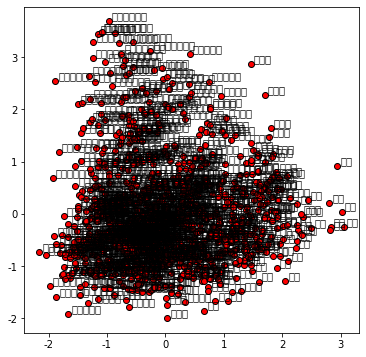

In [6]:
embd_dict = pickle.load(open('embd_last.pkl', 'rb'))
words = list(embd_dict.keys())
embd  = np.array(list(embd_dict.values())).reshape(1000, 768)
draw_pca(words, embd)